In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
from fastai.vision import *
from fastai.metrics import error_rate
from io import BytesIO
from google.cloud import storage

In [9]:
np.random.seed(2)

In [10]:
bs = 64

In [11]:
#Random tranform for training model
tfms = get_transforms()
d_path = Path('data')

pd.read_csv(d_path/'labels.csv').head()

,image_id,healthy,multiple_diseases,rust,scab
0,train/Train_0.jpg,0,0,0,1
1,train/Train_1.jpg,0,1,0,0
2,train/Train_2.jpg,1,0,0,0
3,train/Train_3.jpg,0,0,1,0
4,train/Train_4.jpg,1,0,0,0


In [12]:
classes = ['healthy', 'multiple_diseases','rust','scab']
data = ImageDataBunch.from_csv(d_path, ds_tfms=tfms, label_col=classes, size=224, bs=bs)

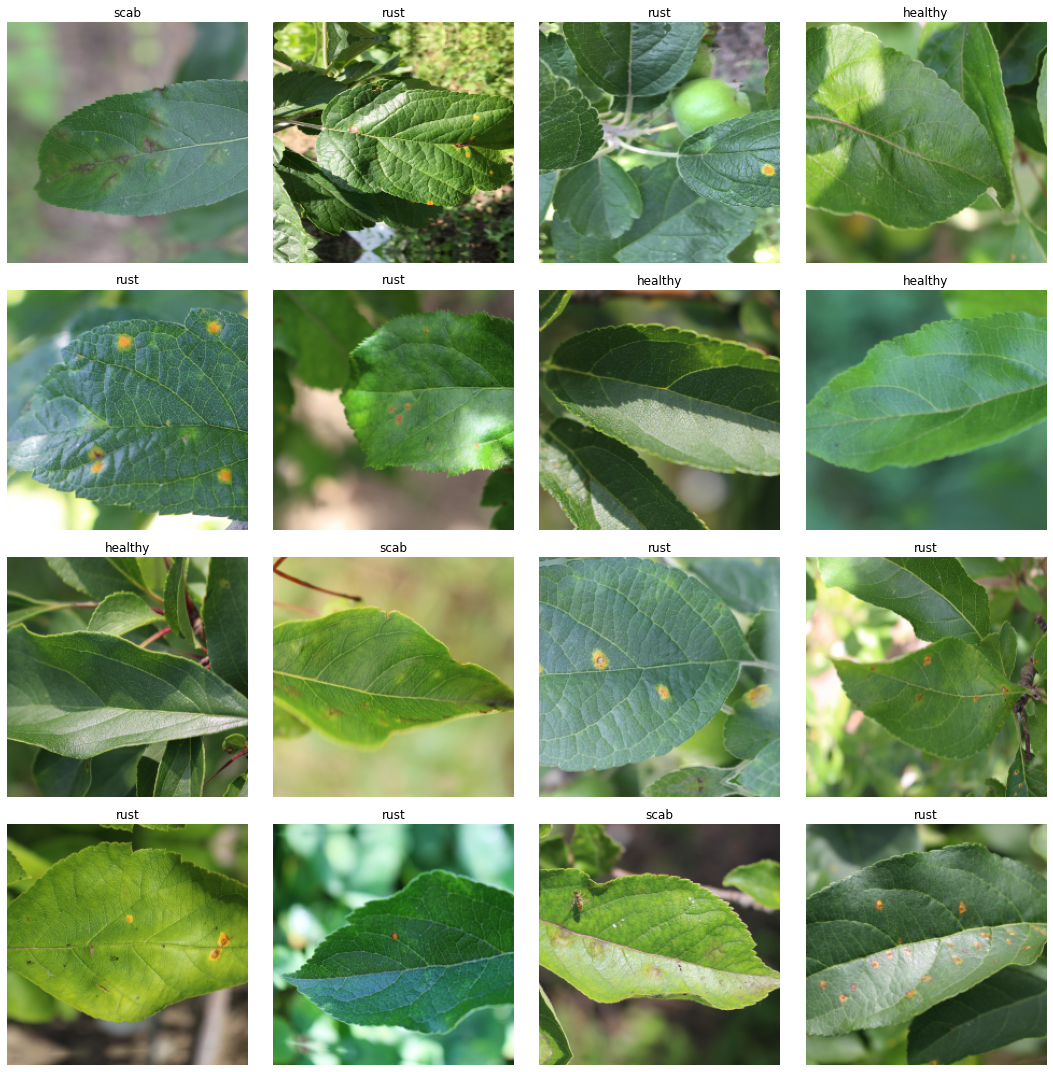

In [13]:
data.show_batch(rows=4, figsize=(15,15))

In [25]:
foliar_learner = cnn_learner(data, models.resnet34, metrics=error_rate)

In [19]:
foliar_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


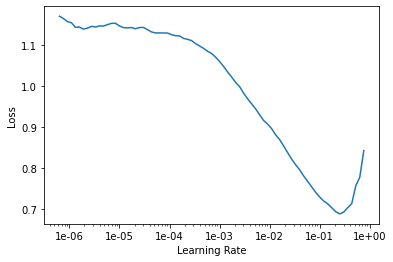

In [20]:
foliar_learner.recorder.plot()

In [28]:
# remember we want training loss less than validation loss. If this doesn't 
# happen, we either have too few epochs or our learning rate is too small. 
foliar_learner.fit_one_cycle(4, max_lr=slice(3e-2, 1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,0.439871,2.547265,0.934066,00:43
1,0.416932,0.906449,0.963599,00:45
2,0.344990,0.265425,0.871566,00:45
3,0.271951,0.151288,0.782967,00:44


In [29]:
# So training loss is still greater than validation loss. let's
# try sticking with the same learning rate, but running a few more cycles.
foliar_learner.fit_one_cycle(4, max_lr=slice(3e-2, 1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,0.122340,0.121093,0.802198,00:45
1,0.130464,0.286253,0.808379,00:45
2,0.144549,0.166749,0.794643,00:45
3,0.125419,0.132165,0.795330,00:45


In [30]:
interp = ClassificationInterpretation.from_learner(foliar_learner)
losses, idxs = interp.top_losses()

29 misclassified samples over 364 samples in the validation set.


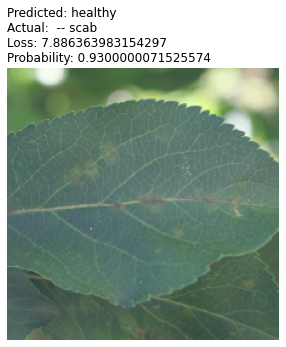

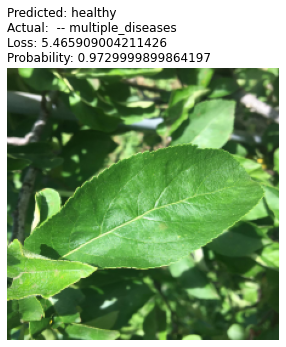

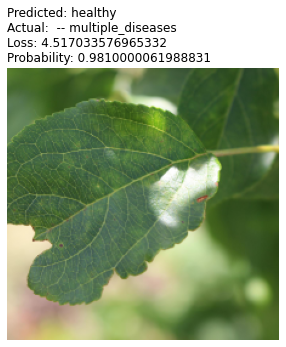

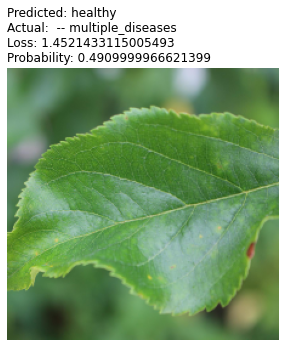

In [38]:
interp.plot_multi_top_losses(4, figsize=(5,5))

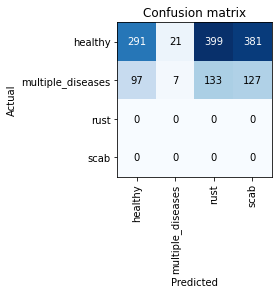

In [40]:
interp.plot_confusion_matrix()